In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
sys.path.append('../common')
import collect_dem

In [3]:
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('text', usetex=True)
font_size = 18
rc('font', size=font_size)
rc('axes', titlesize=font_size)

In [4]:
center = 34.741937, -116.747471
width = 15.0
ll = (center[0] - width, center[1] - width)
ur = (center[0] + width, center[1] + width)
bounds = (*ll, *ur)

In [5]:
zoom = 5
proj = 'utm11S'
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, 200)
tris = scipy.spatial.Delaunay(np.vstack((LON, LAT)).T).simplices.copy()

proj_pts = collect_dem.project(LON, LAT, DEM, proj)
proj_m = (proj_pts, tris)

FileNotFoundError: [Errno 2] No such file or directory: '../common/mapzenapikey'

In [71]:
proj_m[0][np.isnan(proj_m[0])] = 0

<IPython.core.display.Javascript object>


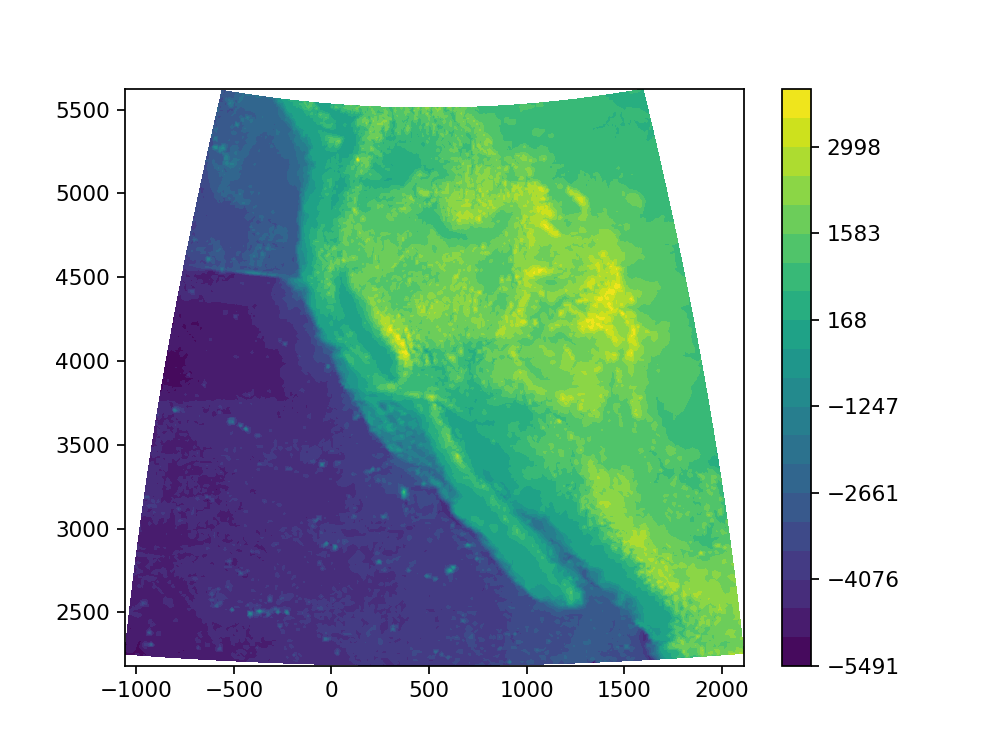

In [72]:
%matplotlib notebook
plt.figure()
min_z = np.min(proj_m[0][:,2])
max_z = np.max(proj_m[0][:,2])
levels = np.linspace(min_z, max_z, 21)
plt.tricontourf(proj_m[0][:,0] / 1000., proj_m[0][:,1] / 1000., proj_m[1], proj_m[0][:,2], levels = levels)
plt.colorbar()
plt.show()

In [4]:
fault_data = open('landers_fault', 'r').read()

rows = fault_data.split('\n')
raw_fault_segs = []
for r in rows:
    if len(r) == 0:
        continue
    cols = r.split(' ')
    segment_name = ''
    for c_idx in range(len(cols)):
        if cols[c_idx][0].isalpha():
            segment_name += cols[c_idx] + ' '
        else:
            break
    lat = float(cols[c_idx])
    lon = float(cols[c_idx + 1])
    length_km = float(cols[c_idx + 2])
    azimuth_deg_ccw_from_east = float(cols[c_idx + 3])
    slip_cm = float(cols[c_idx + 4])
    raw_fault_segs.append((segment_name, lat, lon, length_km, azimuth_deg_ccw_from_east, slip_cm))

In [5]:
from pyproj import Geod
g = Geod(ellps = 'WGS84')
fault_edges = []
for s in raw_fault_segs:
    center_lat = s[1]
    center_lon = s[2]
    length_m = 0.5 * s[3] * 1000
    az_from_n = -90 - s[4]
    start_lon, start_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, -length_m)
    end_lon, end_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, length_m)
    fault_edges.append(np.array([[start_lat, start_lon], [end_lat, end_lon]]))
fault_edges = np.array(fault_edges)

In [6]:
pts = fault_edges.reshape((-1, 2))
els = np.arange(pts.shape[0]).reshape((-1, 2))
m = (pts, els)

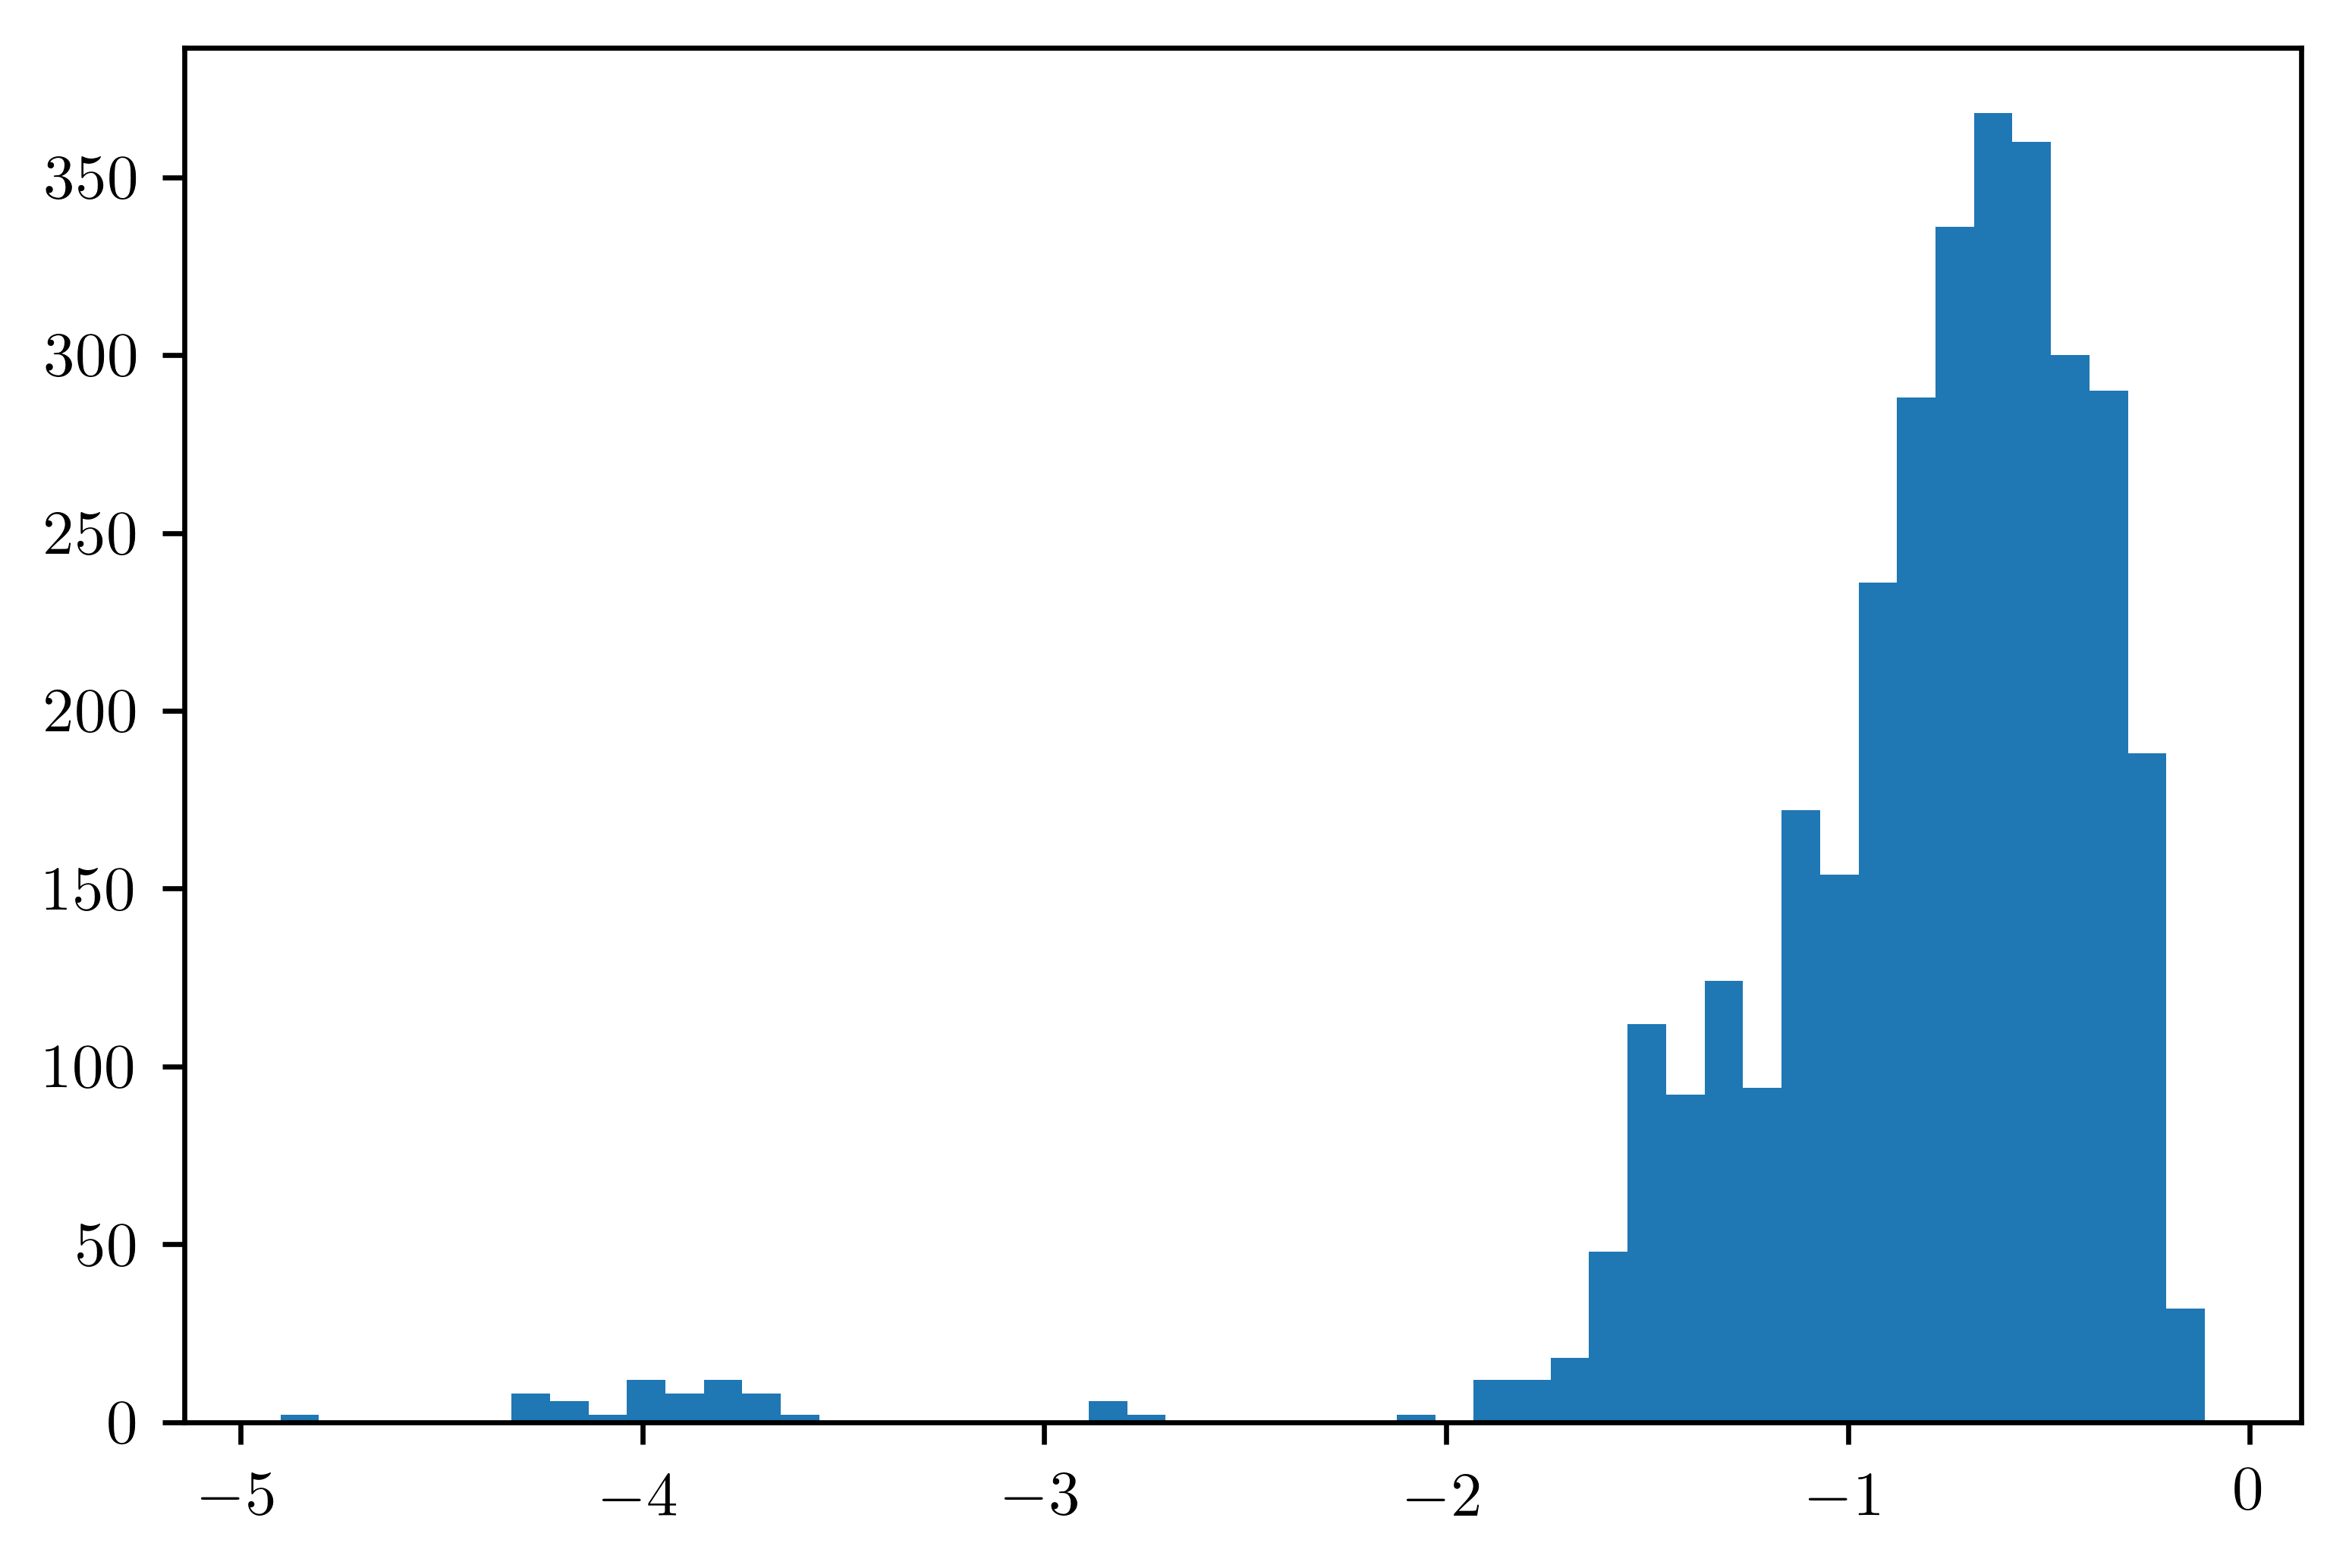

In [7]:
import scipy.spatial.distance
def plot_distance_distribution(m):
    dist = scipy.spatial.distance.cdist(m[0], m[0])
    %matplotlib inline
    plt.hist(np.log10(np.abs(dist[dist > 0])), bins = 50)
    plt.show()
plot_distance_distribution(m)

number of remaining pts: 31


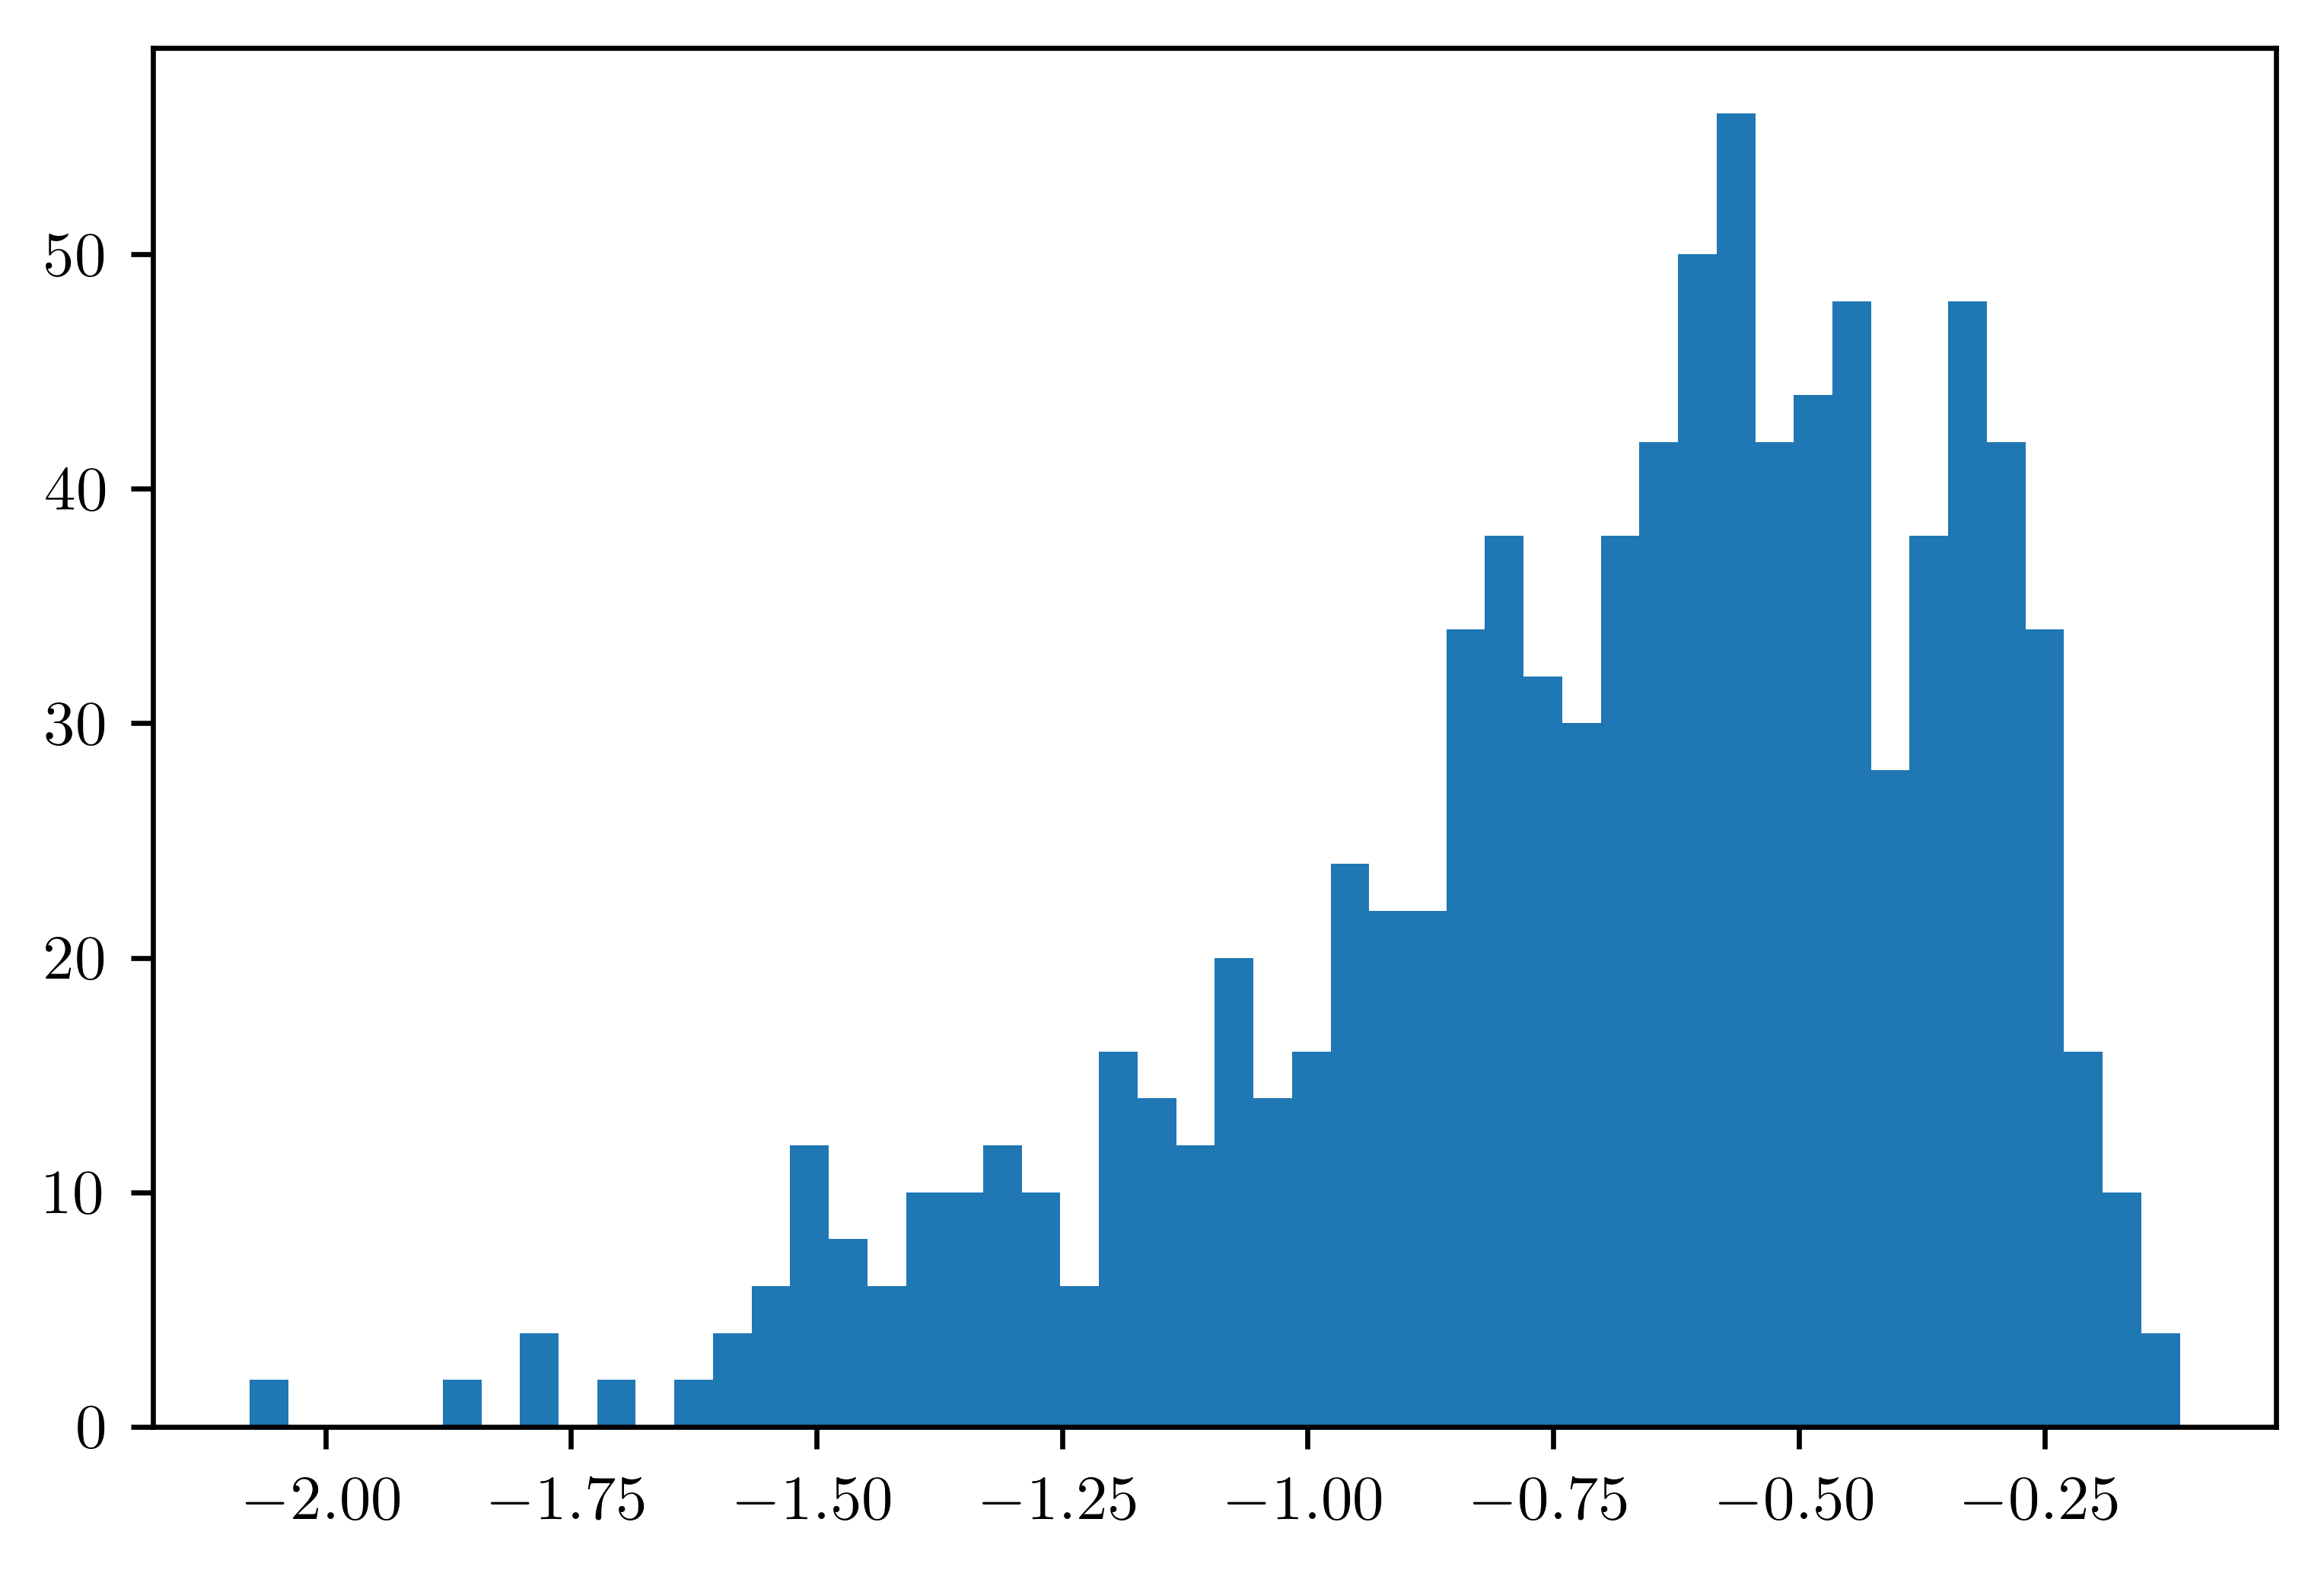

In [11]:
from tectosaur.mesh.modify import remove_duplicate_pts
m_combined = remove_duplicate_pts(remove_duplicate_pts((pts, els), 6e-3), 5e-3)
print('number of remaining pts: ' + str(m_combined[0].shape[0]))
plot_distance_distribution(m_combined)

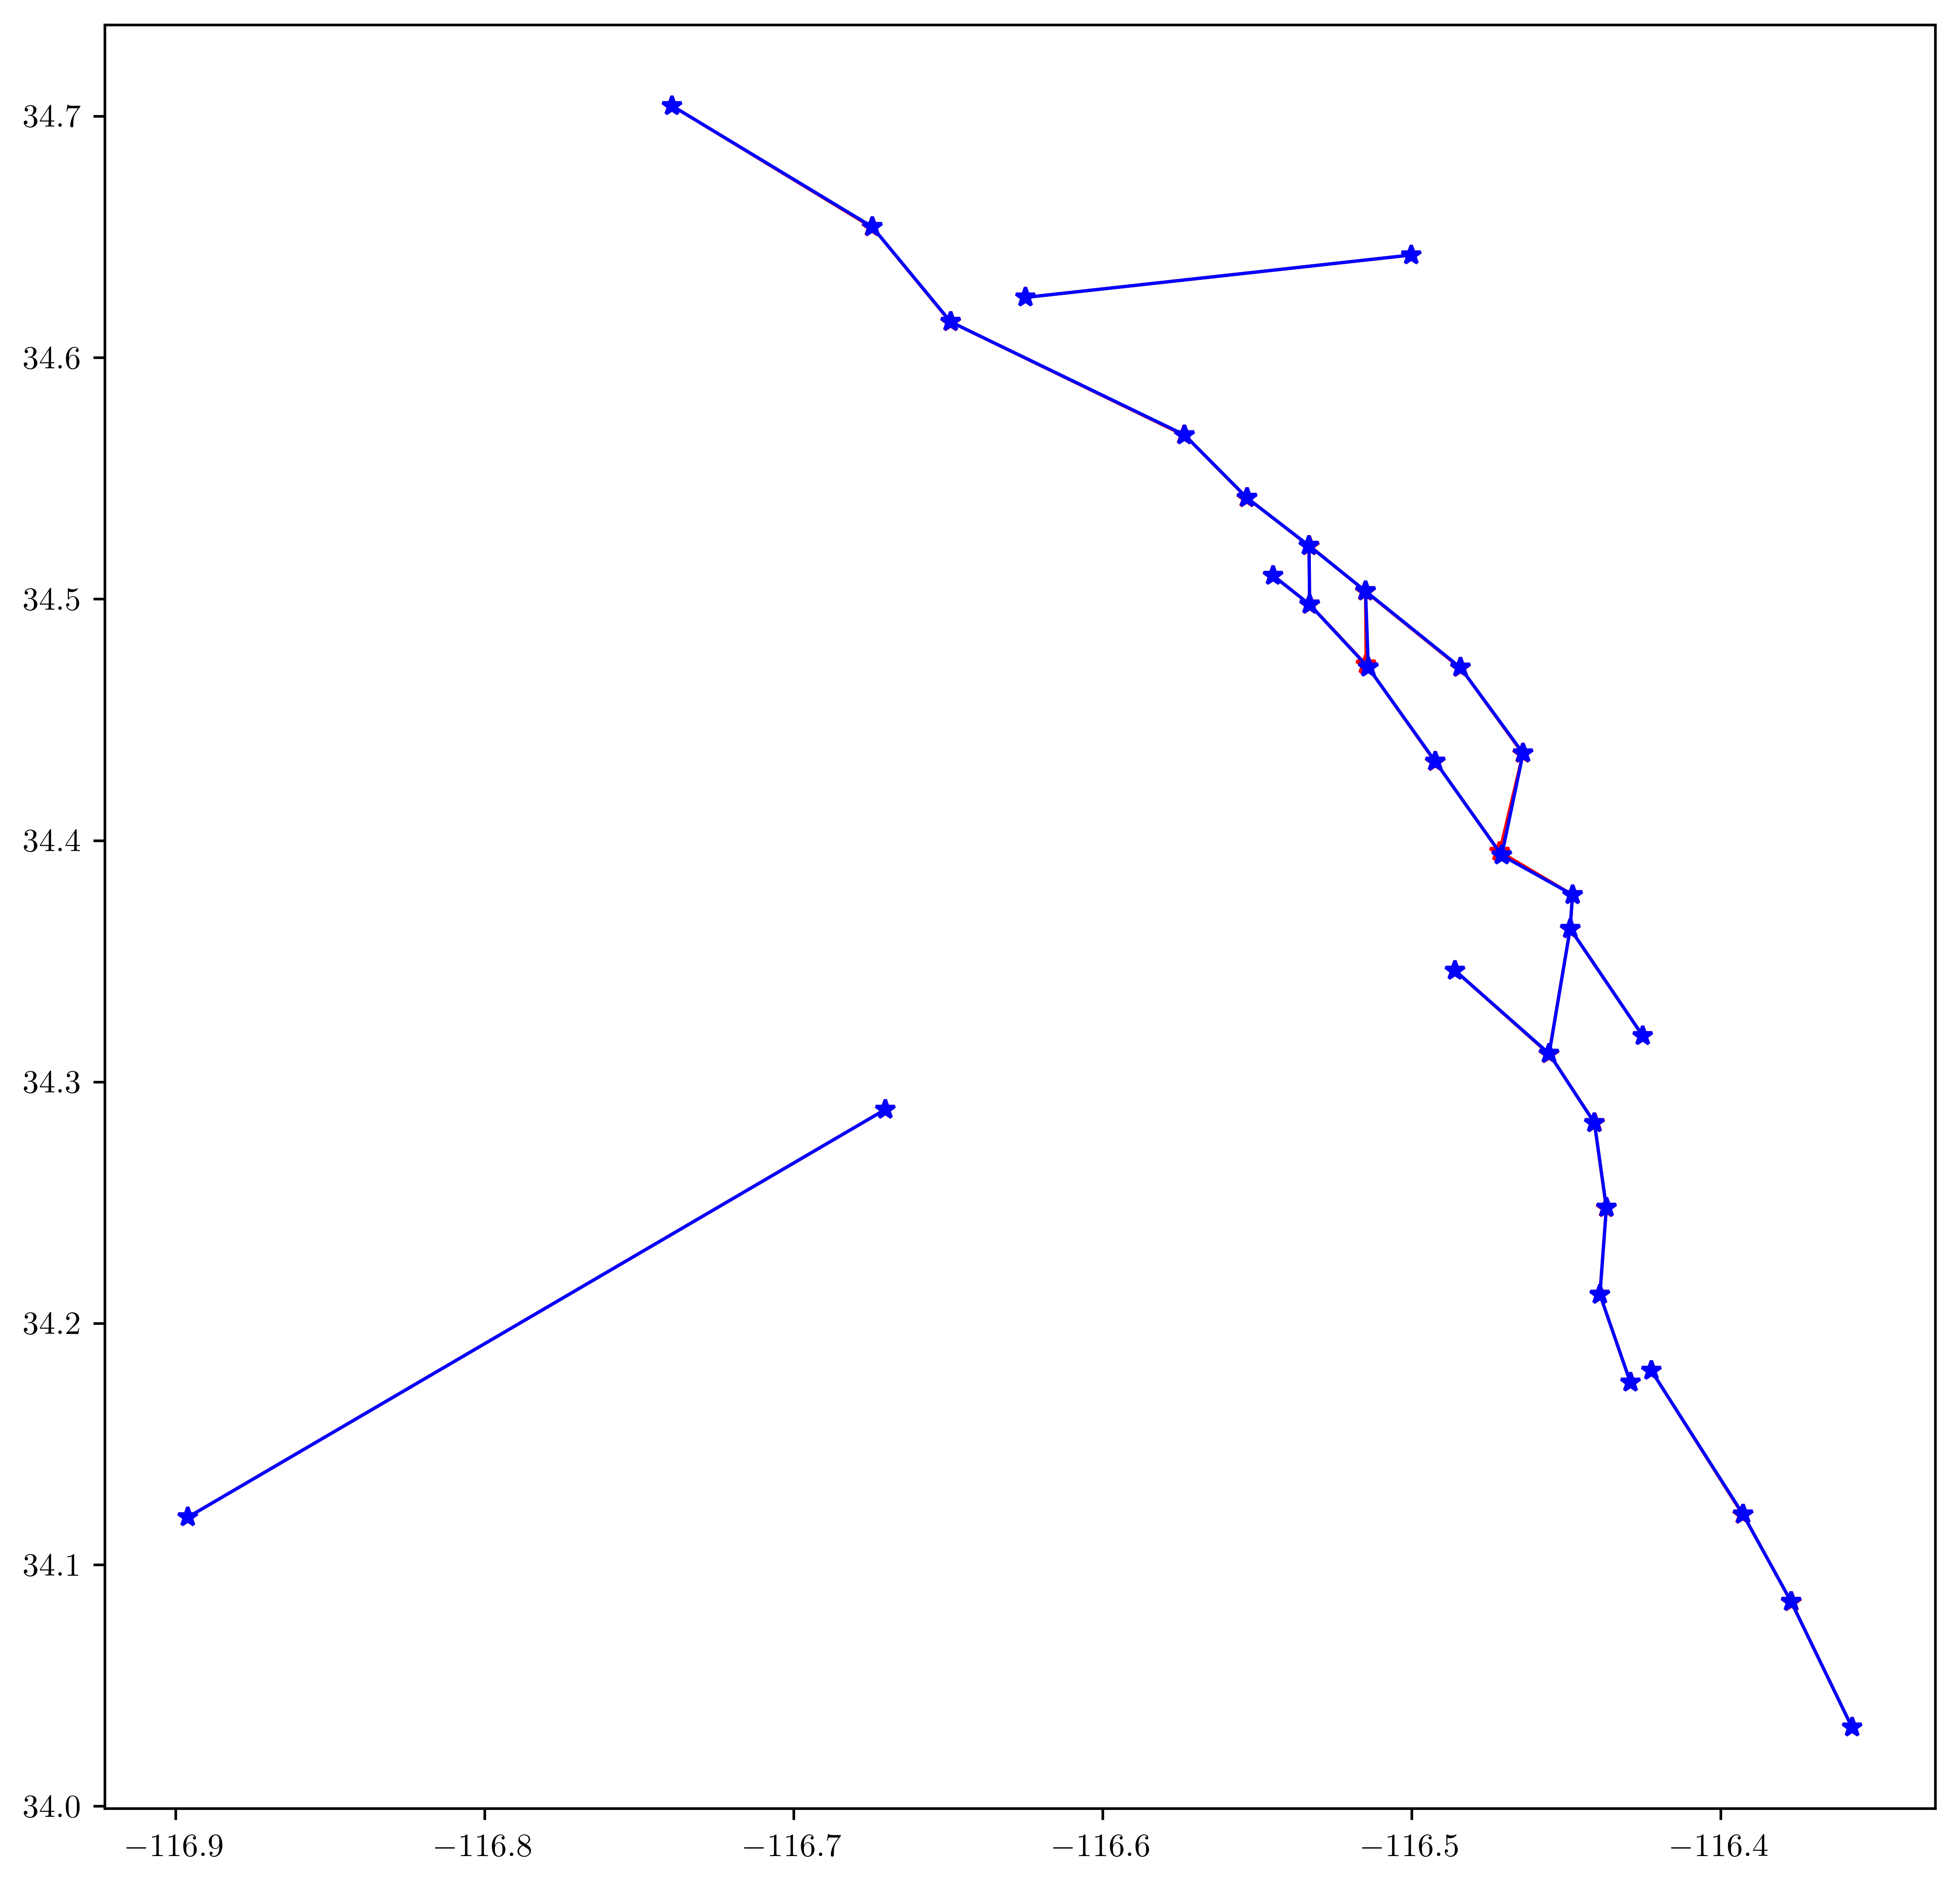

In [12]:
%matplotlib inline
plt.figure(figsize = (10, 10))
for plot_mesh, color in [(m, 'r'), (m_combined, 'b')]:
    for i in range(plot_mesh[1].shape[0]):
        el_pts = plot_mesh[0][plot_mesh[1][i,:]]
        plt.plot(el_pts[:,1], el_pts[:,0], color + '-*', linewidth = 1.0)
plt.show()